In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
   


In [2]:

# Step 1: Load the data
# Ensure the file path is correct for your environment
file_path = 'dataset/ed/finals/16_finalwithsigmoid.csv'

try:
    model_df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file at '{file_path}' was not found. Please check the path.")
    # Exit the script if the file is not found to prevent further errors
    exit()



Data loaded successfully.


In [3]:
# Print the shape and column names to confirm data loading and structure
print(f"Dataset Shape: {model_df.shape}")
print("Columns in the dataset:")
print(model_df.columns.tolist())



Dataset Shape: (591892, 33)
Columns in the dataset:
['subject_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'chiefcomplaint', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'dead_in_days', 'died_within_30_days', 'race_standard', 'age_group', 'unique_visit_id', 'terms', 'terms_new', 'indiv_symptom', 'counter', 'unique_ids_exploded', 'expanded_symptoms', 'expanded_symptoms_new', 'counter_new', 'unique_ids_exploded_new', 'snomed', 'is_male', 'ed_age', 'symptom', 'mu', 'sigma', 'mortality_prob', 'mortality_percent']


In [4]:
# Drop rows with NaNs in either 'mortality_prob' or 'died_within_30_days'
model_df_clean = model_df.dropna(subset=['mortality_prob', 'died_within_30_days'])

# Confirm number of valid rows
print(f"Original rows: {len(model_df)}, After cleaning: {len(model_df_clean)}")


Original rows: 591892, After cleaning: 232895


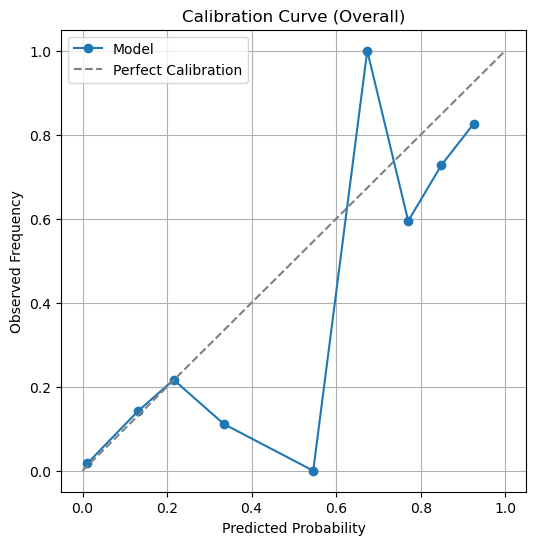

Brier Score: 0.0201


In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Extract columns
y_true = model_df_clean['died_within_30_days']
y_prob = model_df_clean['mortality_prob']

# Compute calibration curve (10 bins)
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Calibration Curve (Overall)')
plt.legend()
plt.grid(True)
plt.show()

# Compute Brier Score
brier = brier_score_loss(y_true, y_prob)
print(f'Brier Score: {brier:.4f}')


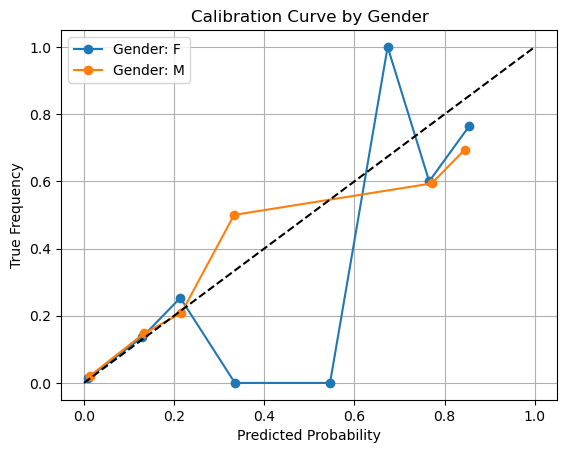

In [6]:
groups = model_df['gender'].unique()

for group in groups:
    sub_df = model_df[model_df['gender'] == group]
    y_true = sub_df['died_within_30_days']
    y_prob = sub_df['mortality_prob']
    
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label=f'Gender: {group}')
    
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Predicted Probability')
plt.ylabel('True Frequency')
plt.title('Calibration Curve by Gender')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# --- Data Preparation and Cleaning ---
# Define the key columns from your dataset
prob_col = 'mortality_prob'
outcome_col = 'died_within_30_days'
# Define the protected attributes for subgroup analysis
subgroup_cols = ['race_standard', 'gender', 'age_group']



In [8]:
# Check if all necessary columns exist in the DataFrame
required_columns = [prob_col, outcome_col] + subgroup_cols
if not all(col in model_df.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in model_df.columns]
    print(f"Error: The dataset is missing one or more required columns: {missing_cols}")
    exit()



In [9]:
# Handle missing values in the probability and outcome columns
# These rows are essential for calibration analysis, so we drop them if missing
initial_rows = len(model_df)
model_df.dropna(subset=[prob_col, outcome_col], inplace=True)
if len(model_df) < initial_rows:
    print(f"Dropped {initial_rows - len(model_df)} rows due to missing '{prob_col}' or '{outcome_col}' values.")

# Ensure the outcome column is of integer type (0 or 1)
# This is crucial for `calibration_curve` and `brier_score_loss`
model_df[outcome_col] = model_df[outcome_col].astype(int)



Dropped 358997 rows due to missing 'mortality_prob' or 'died_within_30_days' values.


In [10]:
# --- 2. Overall Calibration Analysis ---
print("\n--- Overall Calibration Analysis ---")

# Extract the true outcomes and predicted probabilities for the entire dataset
y_true_overall = model_df[outcome_col]
y_prob_overall = model_df[prob_col]

# Calculate the overall Brier score
# The Brier score measures the mean squared difference between predicted probabilities and actual outcomes.
# A lower Brier score indicates better calibration.
brier_score_overall = brier_score_loss(y_true_overall, y_prob_overall)
print(f"Overall Brier Score: {brier_score_overall:.4f}")

# Create the overall calibration plot (Reliability Diagram)
# `calibration_curve` computes the true probabilities for a series of predicted probabilities.
# `n_bins` determines how many bins to use for grouping predicted probabilities.
frac_of_positives_overall, mean_predicted_value_overall = calibration_curve(
    y_true_overall,
    y_prob_overall,
    n_bins=10  # Using 10 bins for the probability range [0, 1]
)




--- Overall Calibration Analysis ---
Overall Brier Score: 0.0201


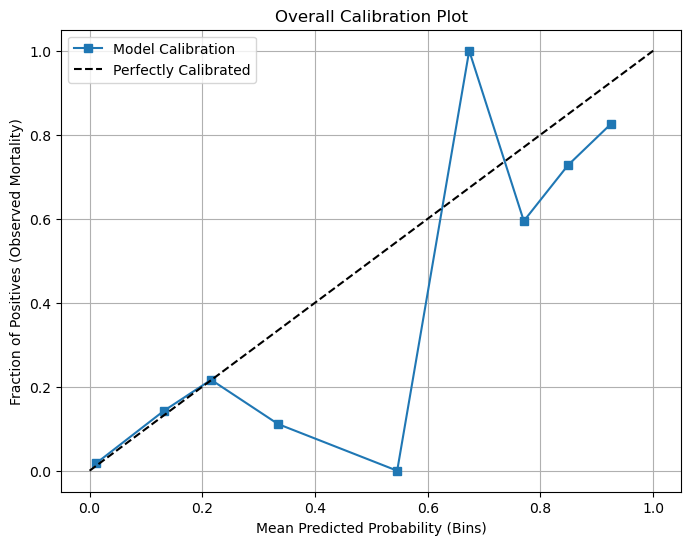

In [11]:
# Plotting the overall calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_overall, frac_of_positives_overall, "s-", label="Model Calibration")
# Add a perfectly calibrated reference line (y=x)
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability (Bins)")
plt.ylabel("Fraction of Positives (Observed Mortality)")
plt.title("Overall Calibration Plot")
plt.legend()
plt.grid(True)
plt.show()




--- Subgroup Calibration Analysis ---

--- Analysis for Subgroup: 'race_standard' ---


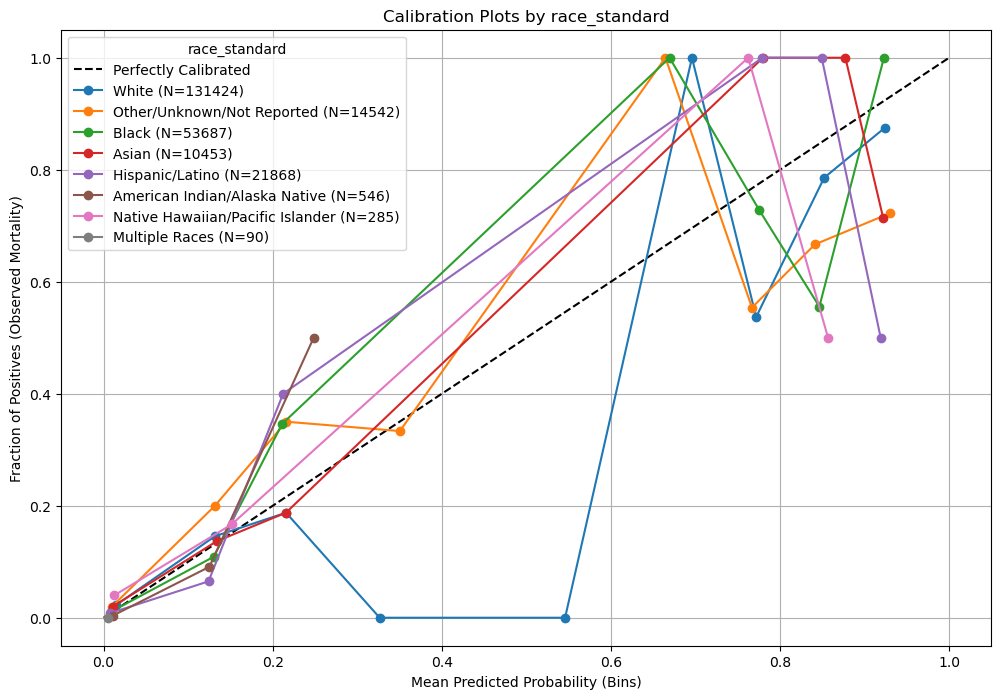

Brier Scores for each group in 'race_standard':
  - White: 0.0248
  - Other/Unknown/Not Reported: 0.0247
  - Black: 0.0119
  - Asian: 0.0212
  - Hispanic/Latino: 0.0082
  - American Indian/Alaska Native: 0.0069
  - Native Hawaiian/Pacific Islander: 0.0444
  - Multiple Races: 0.0003

--- Analysis for Subgroup: 'gender' ---


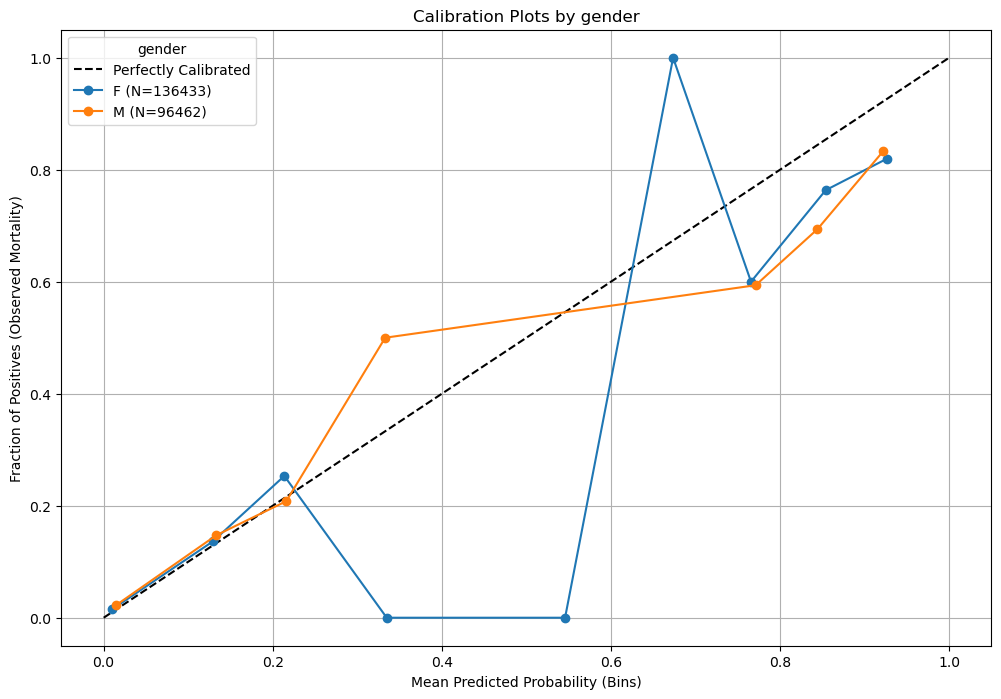

Brier Scores for each group in 'gender':
  - F: 0.0164
  - M: 0.0252

--- Analysis for Subgroup: 'age_group' ---


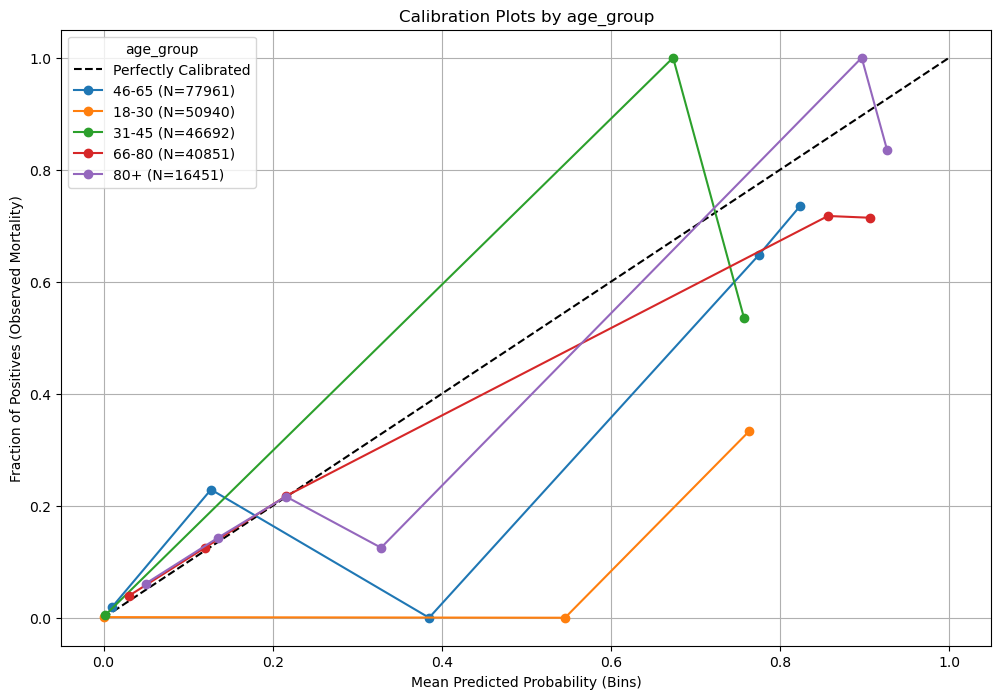

Brier Scores for each group in 'age_group':
  - 46-65: 0.0196
  - 18-30: 0.0012
  - 31-45: 0.0049
  - 66-80: 0.0397
  - 80+: 0.0750


In [12]:
# --- 3. Subgroup Calibration Analysis ---
print("\n--- Subgroup Calibration Analysis ---")

# Iterate through each defined protected attribute for subgroup analysis
for subgroup_col in subgroup_cols:
    print(f"\n--- Analysis for Subgroup: '{subgroup_col}' ---")
    
    # Get unique categories within the current subgroup column
    # Dropna is used here to ensure we only consider valid categories for iteration
    unique_groups = model_df[subgroup_col].dropna().unique()
    
    # Create a new figure for each subgroup type (e.g., one for race, one for gender)
    plt.figure(figsize=(12, 8))
    # Add the perfectly calibrated reference line to each subgroup plot
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    
    # Dictionary to store Brier scores for numerical comparison across groups
    brier_scores_by_group = {}
    
    # Loop through each unique group within the current subgroup column
    for group in unique_groups:
        # Filter the DataFrame to get data for the current group
        # Using .copy() to avoid SettingWithCopyWarning
        subset = model_df[model_df[subgroup_col] == group].copy()
        
        # Ensure there is data for the current group before proceeding
        if len(subset) > 0:
            y_true_subgroup = subset[outcome_col]
            y_prob_subgroup = subset[prob_col]

            # Calculate Brier score for the current subgroup
            brier_score_sub = brier_score_loss(y_true_subgroup, y_prob_subgroup)
            brier_scores_by_group[group] = brier_score_sub
            
            # Generate calibration curve points for the current subgroup
            frac_of_positives_sub, mean_predicted_value_sub = calibration_curve(
                y_true_subgroup, 
                y_prob_subgroup, 
                n_bins=10
            )
            
            # Plot the calibration curve for the current subgroup
            # Include the number of samples (N) in the label for context
            plt.plot(mean_predicted_value_sub, frac_of_positives_sub, marker='o', linestyle='-', label=f"{group} (N={len(subset)})")
        else:
            print(f"Warning: No data found for group: '{group}' in '{subgroup_col}'. Skipping.")

    # Set plot labels and title for the subgroup calibration plot
    plt.xlabel("Mean Predicted Probability (Bins)")
    plt.ylabel("Fraction of Positives (Observed Mortality)")
    plt.title(f"Calibration Plots by {subgroup_col}")
    plt.legend(title=subgroup_col)
    plt.grid(True)
    plt.show()
    
    # Print the Brier scores for numerical comparison across groups
    print(f"Brier Scores for each group in '{subgroup_col}':")
    for group, score in brier_scores_by_group.items():
        print(f"  - {group}: {score:.4f}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Step 1: Load the data
# Ensure the file path is correct for your environment
file_path = 'dataset/ed/finals/16_finalwithsigmoid.csv'

try:
    model_df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file at '{file_path}' was not found. Please check the path.")
    # Exit the script if the file is not found to prevent further errors
    exit()

# Print the shape and column names to confirm data loading and structure
print(f"Dataset Shape: {model_df.shape}")
print("Columns in the dataset:")
print(model_df.columns.tolist())

# --- Data Preparation and Cleaning ---
# Define the key columns from your dataset
prob_col = 'mortality_prob'
outcome_col = 'died_within_30_days'
# Define the protected attributes for subgroup analysis
subgroup_cols = ['race_standard', 'gender', 'age_group']

# Check if all necessary columns exist in the DataFrame
required_columns = [prob_col, outcome_col] + subgroup_cols
if not all(col in model_df.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in model_df.columns]
    print(f"Error: The dataset is missing one or more required columns: {missing_cols}")
    exit()

# Handle missing values in the probability and outcome columns
# These rows are essential for calibration analysis, so we drop them if missing
initial_rows = len(model_df)
model_df.dropna(subset=[prob_col, outcome_col], inplace=True)
if len(model_df) < initial_rows:
    print(f"Dropped {initial_rows - len(model_df)} rows due to missing '{prob_col}' or '{outcome_col}' values.")

# Ensure the outcome column is of integer type (0 or 1)
# This is crucial for `calibration_curve` and `brier_score_loss`
model_df[outcome_col] = model_df[outcome_col].astype(int)

# --- 2. Overall Calibration Analysis ---
print("\n--- Overall Calibration Analysis ---")

# Extract the true outcomes and predicted probabilities for the entire dataset
y_true_overall = model_df[outcome_col]
y_prob_overall = model_df[prob_col]

# Calculate the overall Brier score
# The Brier score measures the mean squared difference between predicted probabilities and actual outcomes.
# A lower Brier score indicates better calibration.
brier_score_overall = brier_score_loss(y_true_overall, y_prob_overall)
print(f"Overall Brier Score: {brier_score_overall:.4f}")

# Create the overall calibration plot (Reliability Diagram)
# `calibration_curve` computes the true probabilities for a series of predicted probabilities.
# `n_bins` determines how many bins to use for grouping predicted probabilities.
frac_of_positives_overall, mean_predicted_value_overall = calibration_curve(
    y_true_overall,
    y_prob_overall,
    n_bins=10  # Using 10 bins for the probability range [0, 1]
)

# Plotting the overall calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_overall, frac_of_positives_overall, "s-", label="Model Calibration")
# Add a perfectly calibrated reference line (y=x)
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability (Bins)")
plt.ylabel("Fraction of Positives (Observed Mortality)")
plt.title("Overall Calibration Plot")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Subgroup Calibration Analysis ---
print("\n--- Subgroup Calibration Analysis ---")

# Iterate through each defined protected attribute for subgroup analysis
for subgroup_col in subgroup_cols:
    print(f"\n--- Analysis for Subgroup: '{subgroup_col}' ---")
    
    # Get unique categories within the current subgroup column
    # Dropna is used here to ensure we only consider valid categories for iteration
    unique_groups = model_df[subgroup_col].dropna().unique()
    
    # Create a new figure for each subgroup type (e.g., one for race, one for gender)
    plt.figure(figsize=(12, 8))
    # Add the perfectly calibrated reference line to each subgroup plot
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    
    # Dictionary to store Brier scores for numerical comparison across groups
    brier_scores_by_group = {}
    
    # Loop through each unique group within the current subgroup column
    for group in unique_groups:
        # Filter the DataFrame to get data for the current group
        # Using .copy() to avoid SettingWithCopyWarning
        subset = model_df[model_df[subgroup_col] == group].copy()
        
        # Ensure there is data for the current group before proceeding
        if len(subset) > 0:
            y_true_subgroup = subset[outcome_col]
            y_prob_subgroup = subset[prob_col]

            # Calculate Brier score for the current subgroup
            brier_score_sub = brier_score_loss(y_true_subgroup, y_prob_subgroup)
            brier_scores_by_group[group] = brier_score_sub
            
            # Generate calibration curve points for the current subgroup
            frac_of_positives_sub, mean_predicted_value_sub = calibration_curve(
                y_true_subgroup, 
                y_prob_subgroup, 
                n_bins=10
            )
            
            # Plot the calibration curve for the current subgroup
            # Include the number of samples (N) in the label for context
            plt.plot(mean_predicted_value_sub, frac_of_positives_sub, marker='o', linestyle='-', label=f"{group} (N={len(subset)})")
        else:
            print(f"Warning: No data found for group: '{group}' in '{subgroup_col}'. Skipping.")

    # Set plot labels and title for the subgroup calibration plot
    plt.xlabel("Mean Predicted Probability (Bins)")
    plt.ylabel("Fraction of Positives (Observed Mortality)")
    plt.title(f"Calibration Plots by {subgroup_col}")
    plt.legend(title=subgroup_col)
    plt.grid(True)
    plt.show()
    
    # Print the Brier scores for numerical comparison across groups
    print(f"Brier Scores for each group in '{subgroup_col}':")
    for group, score in brier_scores_by_group.items():
        print(f"  - {group}: {score:.4f}")

In [ ]:

# Step 1: Load the data
# Ensure the file path is correct for your environment
file_path = 'dataset/ed/finals/16_finalwithsigmoid.csv' # UPDATED FILE PATH

try:
    model_df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file at '{file_path}' was not found. Please check the path.")
    exit()

# Print the shape and column names to confirm data loading and structure
print(f"Initial Dataset Shape: {model_df.shape}")
print("Columns in the dataset:")
print(model_df.columns.tolist())

# --- Data Preparation and Cleaning ---
# Define the key columns from your dataset
prob_col = 'mortality_prob'
outcome_col = 'died_within_30_days' # This will be re-calculated
subgroup_cols = ['race_standard', 'gender', 'age_group']

# Check if all necessary columns exist in the DataFrame for the calculation
required_for_calc = ['intime', 'dod', prob_col] + subgroup_cols
if not all(col in model_df.columns for col in required_for_calc):
    missing_cols = [col for col in required_for_calc if col not in model_df.columns]
    print(f"Error: The dataset is missing one or more required columns for processing: {missing_cols}")
    exit()

# Convert 'intime' and 'dod' to datetime objects for calculation
model_df['intime'] = pd.to_datetime(model_df['intime'])
model_df['dod'] = pd.to_datetime(model_df['dod'])

# --- Recalculate 'died_within_30_days' based on your logic ---
# If 'dod' is NaN, patient is considered alive, so died_within_30_days is 0.
# If 'dod' is not NaN, calculate days to death and check if <= 30.
def calculate_died_within_30_days(row):
    if pd.isna(row['dod']):
        return 0 # Patient is alive (dod is blank)
    else:
        time_diff = (row['dod'] - row['intime']).days
        return 1 if time_diff <= 30 else 0

initial_died_within_30_days_nan_count = model_df[outcome_col].isna().sum()
model_df[outcome_col] = model_df.apply(calculate_died_within_30_days, axis=1)
print(f"Recalculated '{outcome_col}'. Number of NaNs before: {initial_died_within_30_days_nan_count}, after: {model_df[outcome_col].isna().sum()}")

# Now, handle missing 'mortality_prob' values.
# For calibration, we *must* have a predicted probability.
# We will filter the DataFrame for rows where 'mortality_prob' is NOT NaN.
initial_rows_for_calibration = len(model_df)
analysis_df = model_df.dropna(subset=[prob_col]).copy() # Use a copy to avoid modifying original df for other potential analyses

rows_dropped_for_calibration = initial_rows_for_calibration - len(analysis_df)
if rows_dropped_for_calibration > 0:
    print(f"Dropped {rows_dropped_for_calibration} rows for calibration analysis due to missing '{prob_col}' values.")
    print("Calibration can only be performed on data points where a predicted probability exists.")
else:
    print("No rows dropped for calibration analysis due to missing 'mortality_prob' values.")

# Ensure the outcome column is of integer type (0 or 1) in the analysis_df
analysis_df[outcome_col] = analysis_df[outcome_col].astype(int)

# --- 2. Overall Calibration Analysis ---
print("\n--- Overall Calibration Analysis ---")

# Extract the true outcomes and predicted probabilities for the entire dataset used for analysis
y_true_overall = analysis_df[outcome_col]
y_prob_overall = analysis_df[prob_col]

# Calculate the overall Brier score
brier_score_overall = brier_score_loss(y_true_overall, y_prob_overall)
print(f"Overall Brier Score (on {len(analysis_df)} samples): {brier_score_overall:.4f}")

# Create the overall calibration plot (Reliability Diagram)
frac_of_positives_overall, mean_predicted_value_overall = calibration_curve(
    y_true_overall,
    y_prob_overall,
    n_bins=10  # Using 10 bins for the probability range [0, 1]
)

# Plotting the overall calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_overall, frac_of_positives_overall, "s-", label="Model Calibration")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability (Bins)")
plt.ylabel("Fraction of Positives (Observed Mortality)")
plt.title("Overall Calibration Plot")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Subgroup Calibration Analysis ---
print("\n--- Subgroup Calibration Analysis ---")

# Iterate through each defined protected attribute for subgroup analysis
for subgroup_col in subgroup_cols:
    print(f"\n--- Analysis for Subgroup: '{subgroup_col}' ---")
    
    # Get unique categories within the current subgroup column from the analysis_df
    # Dropna is used here to ensure we only consider valid categories for iteration
    unique_groups = analysis_df[subgroup_col].dropna().unique()
    
    # Create a new figure for each subgroup type (e.g., one for race, one for gender)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    
    # Dictionary to store Brier scores for numerical comparison across groups
    brier_scores_by_group = {}
    
    # Loop through each unique group within the current subgroup column
    for group in unique_groups:
        # Filter the analysis_df to get data for the current group
        subset = analysis_df[analysis_df[subgroup_col] == group].copy()
        
        # Ensure there is data for the current group before proceeding
        if len(subset) > 0:
            y_true_subgroup = subset[outcome_col]
            y_prob_subgroup = subset[prob_col]

            # Calculate Brier score for the current subgroup
            brier_score_sub = brier_score_loss(y_true_subgroup, y_prob_subgroup)
            brier_scores_by_group[group] = brier_score_sub
            
            # Generate calibration curve points for the current subgroup
            frac_of_positives_sub, mean_predicted_value_sub = calibration_curve(
                y_true_subgroup, 
                y_prob_subgroup, 
                n_bins=10
            )
            
            # Plot the calibration curve for the current subgroup
            plt.plot(mean_predicted_value_sub, frac_of_positives_sub, marker='o', linestyle='-', label=f"{group} (N={len(subset)})")
        else:
            print(f"Warning: No data found for group: '{group}' in '{subgroup_col}' within the analyzed dataset. Skipping.")

    # Set plot labels and title for the subgroup calibration plot
    plt.xlabel("Mean Predicted Probability (Bins)")
    plt.ylabel("Fraction of Positives (Observed Mortality)")
    plt.title(f"Calibration Plots by {subgroup_col}")
    plt.legend(title=subgroup_col)
    plt.grid(True)
    plt.show()
    
    # Print the Brier scores for numerical comparison across groups
    print(f"Brier Scores for each group in '{subgroup_col}':")
    for group, score in brier_scores_by_group.items():
        print(f"  - {group}: {score:.4f}")

In [ ]:
print("\n--- Analysis of Missing 'mortality_prob' by Subgroup ---")
missing_prob_df = model_df[model_df['mortality_prob'].isna()]

for col in subgroup_cols:
    if not missing_prob_df.empty:
        print(f"\nMissing '{prob_col}' counts by '{col}':")
        total_counts = model_df[col].value_counts(dropna=False)
        missing_counts = missing_prob_df[col].value_counts(dropna=False)

        # Combine and calculate percentage
        missing_percentage = (missing_counts / total_counts * 100).fillna(0)

        print(pd.DataFrame({
            'Total Samples': total_counts,
            'Missing Prob Samples': missing_counts.fillna(0).astype(int),
            'Missing Prob %': missing_percentage.round(2)
        }).sort_values(by='Missing Prob %', ascending=False))
    else:
        print(f"No missing '{prob_col}' values to analyze by '{col}'.")